# Issues with CAFE-f6

While spinning up this project, I discovered a number of issues with the CAFE-f6 forecasts that must be contended with when assessing the hindcasts.

These issues are breifly described/demonstrated in this notebook.

In [1]:
import os
import glob
import subprocess

import time
import cftime

import xarray as xr

import matplotlib.pyplot as plt

from src import utils

from distributed import Client

In [2]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

In [3]:
%load_ext lab_black

## 1. Application of forcing

Some of the forcing fields in the CAFE-f6 forecasts are applied in a way that is different that the CMIP DCPP recomendations. Principally, a number of the forcing fields switch from time-varying to fixed based on the *initialisation date* of the forecasts. **This means that the same calendar year can experience different forcing, depending on its lead time.** For example (see below), The lead 2 year forecast of 2002 (initialised 2000) will be forced with 2002 volcanic forcing, but the lead 1 forecast of 2002 (initialised 2001) will be forced with 2008 forcing. This could make the forecasts difficult to interpret and baseline.

The relevant lines that specify the forcing in the CAFE-f6 model namelist (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/ref/MODEL/input.in) are:

```
 &aerosol_nml
    use_aerosol_timeseries = .false.
    aerosol_dataset_entry =  INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
                             INPUT_AEROSOL_TIME,
    family_names = "small_dust", "large_dust", "sulfate", "aerosol"
    in_family1 = F,F,F,F,T,T,T,T,T,F,F,F,
    in_family2 = F,F,F,F,F,F,F,F,F,T,T,T,
    in_family3 = T,F,F,F,F,F,F,F,F,F,F,F,
    in_family4 = T,T,T,T,T,T,T,T,T,T,T,T,
    data_names = "so4", "organic_carbon", "black_carbon", "sea_salt",
                 "dust_0.1", "dust_0.2", "dust_0.4", "dust_0.8",
                 "dust_1.0", "dust_2.0", "dust_4.0", "dust_8.0",
    filename = "aerosol.climatology.nc"
/
 &aerosolrad_package_nml
    volcanic_dataset_entry = 1, 1, 1, 0, 0, 0,
    REPEAT_VOLCANO_YEAR
    VOLCANO_YEAR_USED
    using_volcanic_lw_files = .false.,
    lw_ext_filename = "             "
    lw_ext_root = "     "
    lw_asy_filename = "             "
    lw_asy_root = "     "
    lw_ssa_filename = "             "
    lw_ssa_root = "     "
    using_volcanic_sw_files = .true.,
    sw_ext_filename = "extsw_data.nc"
    sw_ext_root = "extsw"
    sw_ssa_filename = "omgsw_data.nc"
    sw_ssa_root = "omgsw"
    sw_asy_filename = "asmsw_data.nc"
    sw_asy_root = "asmsw"
    do_lwaerosol = .true.,
    do_swaerosol = .true.,
    aerosol_data_set = 'shettle_fenn',
    optical_filename = "aerosol.optical.dat",
    aerosol_optical_names = "sulfate_30%", "sulfate_35%", "sulfate_40%", "sulfate_45%",
                            "sulfate_50%", "sulfate_55%", "sulfate_60%", "sulfate_65%",
                            "sulfate_70%", "sulfate_75%", "sulfate_80%", "sulfate_82%",
                            "sulfate_84%", "sulfate_86%", "sulfate_88%", "sulfate_90%",
                            "sulfate_91%", "sulfate_92%", "sulfate_93%", "sulfate_94%",
                            "sulfate_95%", "sulfate_96%", "sulfate_97%", "sulfate_98%",
                            "sulfate_99%", "sulfate_100%","organic_carbon","soot",
                            "sea_salt",    "dust_0.1",    "dust_0.2",    "dust_0.4",
                            "dust_0.8",    "dust_1.0",    "dust_2.0",    "dust_4.0",
                            "dust_8.0"
.
.
.
&ozone_nml
    BASIC_OZONE_TYPE
    OZONE_DATASET_ENTRY
    data_name = "ozone",
    FILENAME
.
.
.
 &radiation_driver_nml
       rad_time_step= 10800,
       time_varying_solar_constant = .false.,
       solar_dataset_entry = 1990,1,1,0,0,0,
       rad_package = 'sea_esf',
       do_clear_sky_pass=.true.,
       calc_hemi_integrals = .false.,
       renormalize_sw_fluxes=.true.,
       all_step_diagnostics = .true.,
       zenith_spec = 'diurnally_varying'
       using_restart_file = .false.
/
 &radiative_gases_nml
       verbose = 3
       gas_printout_freq = 240
       time_varying_co2 = .true.,
       co2_variation_type = 'linear',
       co2_specification_type = 'time_series',
       co2_floor = 100.0E-06,
       co2_ceiling = 1600.0E-06,
       co2_data_source = 'input'
       time_varying_ch4 = .true.,
       ch4_variation_type = 'linear'
       ch4_specification_type = 'time_series'
       ch4_data_source = 'input'
       time_varying_n2o = .true.,
       n2o_variation_type = 'linear'
       n2o_specification_type = 'time_series'
       n2o_data_source = 'input'
       time_varying_f11 = .true.,
       f11_variation_type = 'linear'
       f11_specification_type = 'time_series'
       f11_data_source = 'input'
       time_varying_f12 = .true.,
       f12_variation_type = 'linear'
       f12_specification_type = 'time_series'
       f12_data_source = 'input'
       time_varying_f113 = .true.,
       f113_variation_type = 'linear'
       f113_specification_type = 'time_series'
       f113_data_source = 'input'
       time_varying_f22 = .true.,
       f22_variation_type = 'linear'
       f22_specification_type = 'time_series'
       f22_data_source = 'input'
```

where the following replacements are made before submission (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/src/run_CAFE_forecasts.sh.in):

**a.** Replace
 
```
INPUT_AEROSOL_TIME -> "AYEAR, 1, 1, 0, 0, 0"
```
   
  where `AYEAR` is the middle year of the decade in which the forecast is initialised (e.g. `AYEAR`=2005 for any start date in the 2000s). If `AYEAR` is greater than 2015, then 2015 is used.
   
**b.** If the forecast is initialised after 2000 then replace,
 
```
REPEAT_VOLCANO_YEAR -> "repeat_volcano_year=.true."
VOLCANO_YEAR_USED -> "volcano_year_used = 2008,"
```

otherwise these lines are commented out.
   
**c.** If the forecast is initialised after 2004 then replace,

```
BASIC_OZONE_TYPE -> "fixed_year"
OZONE_DATASET_ENTRY -> "ozone_dataset_entry=2014, 1, 1, 0, 0, 0,"
FILENAME -> "cm3_2014_o3.padded.nc"
```

otherwise replace,

```
BASIC_OZONE_TYPE -> "time_varying"
FILENAME -> "CM3_CMIP6_1950-2014_O3.nc"
```

and `OZONE_DATASET_ENTRY` is commented out.

In addition, the following is added to the field table (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/ref/MODEL/field_table_bgc):

**d.** If the forecast is initialised after 2007 then,

```
aco2_file = "INPUT/co2_obs.padded.nc"
```

otherwise,

```
aco2_file = "INPUT/co2_obs.nc"
```

I've been told these files are used by the bgc component of the model. Notably, `co2_obs.padded.nc` includes projected values into the future, but both files are identical (see below) in their overlapping period so the switch from `co2_obs.nc` to `co2_obs.padded.nc` seems to be redundant.

Forcing files are copied from `/g/data/v14/vxk563/CAFE/CM21_c5/INIT/STATIC/` when a forecast is run (see https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/settings.sh#L29 and https://github.com/csiro-dcfp/cm-forecasts/blob/fb22ae161bfce6803435c0d10fa74a9d49e4bffc/src/run_CAFE_forecasts.sh.in#L90)

### So what does this mean?

#### Aerosols climatologies

Aerosol forcing climatologies are provided per decade. Forecasts initialised prior to 2020 are forced using the climatologies corresponding to the decade of their initialialisation (e.g. 2000s forcing climatologies for every forecast initialised in 2000-2009). Forecasts initialised in 2020 of later use the 2010s aerosol forcing climatologies.

**However**, the aerosol climatologies provided are actually identical to the 2000s climatology for all decades after the 2000s:

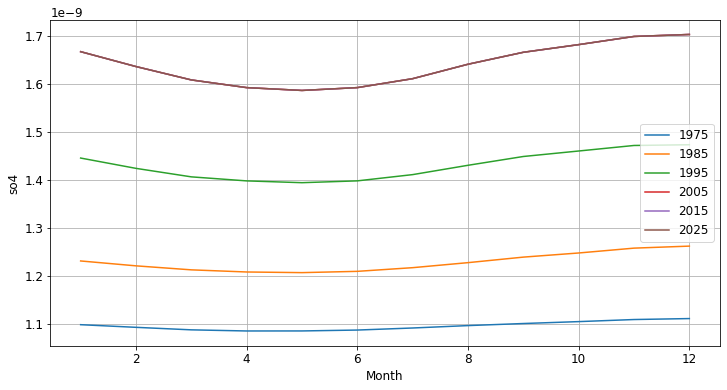

In [4]:
INIT_dir = "/g/data/v14/vxk563/CAFE/CM21_c5/INIT/STATIC/"

ds = xr.open_dataset(f"{INIT_dir}/aerosol.climatology.nc")

periods = range(1975, 2030, 10)
for p in periods:
    so4 = ds["so4"].isel(sigma_full=0).sel(time=str(p)).mean(["lat", "lon"])
    plt.plot(range(1, 13), so4)

plt.xlabel("Month")
plt.ylabel("so4")
plt.grid()
_ = plt.legend(periods)

Therefore

**If initialised during or before 1999, we use the aerosol forcing climatologies corresponding to the decade of initialisation \
If initialised after 1999, we use the aerosol forcing climatologies for the 2000s**

#### Volcanic forcing
Time varying (monthly) volcanic forcing is used for forecasts initialised prior to or during 2000, and 2008 volcanic forcing is used for those initialised after 2000.

**However**, the time-varying volcanic forcing provided is actually identical to 1999-12 for all values after 1999-12:

In [5]:
ds = xr.open_dataset(f"{INIT_dir}/extsw_data.nc")
matched = all(
    (ds.sel(time="1999-12").squeeze() == ds.sel(time=slice("2000", None))).all()
)
print(f"All extsw_data.nc are constant after 1999-12: {matched}")

ds = xr.open_dataset(f"{INIT_dir}/omgsw_data.nc")
matched = all(
    (ds.sel(time="1999-12").squeeze() == ds.sel(time=slice("2000", None))).all()
)
print(f"All omgsw_data.nc are constant after 1999-12: {matched}")

ds = xr.open_dataset(f"{INIT_dir}/asmsw_data.nc")
matched = all(
    (ds.sel(time="1999-12").squeeze() == ds.sel(time=slice("2000", None))).all()
)
print(f"All asmsw_data.nc are constant after 1999-12: {matched}")

All extsw_data.nc are constant after 1999-12: True
All omgsw_data.nc are constant after 1999-12: True
All asmsw_data.nc are constant after 1999-12: True


Therefore

**We use time varying volcanic forcing up until 1999-12, and then 1999-12 levels from 2000-01 onwards. (Because the forcing files don't actually change after 1999-12, the switch to 2008 forcing in our forecast scripts for initialisation dates after 2000 actually does nothing, other than to allow forecasts to be run beyond the maximum time of the forcing files, 2010-12).**

#### Ozone forcing
Time varying (monthly) ozone forcing is used for forecasts initialised prior to or during 2004, and 2014 ozone forcing is used for those initialised after 2004.

Therefore

**If initialised during or before 2004, we use time varying monthly (CMIP6) ozone forcing \
If initialised after 2004, we use the 2014 ozone forcing**

#### Solar forcing
The namelist (see above) suggests that fixed 1990 solar forcing is applied for all forecasts.

#### Radiative gas forcing
These are taken from the `*_gblannualdata` files and are time varying regardless of forecast initialisation date.

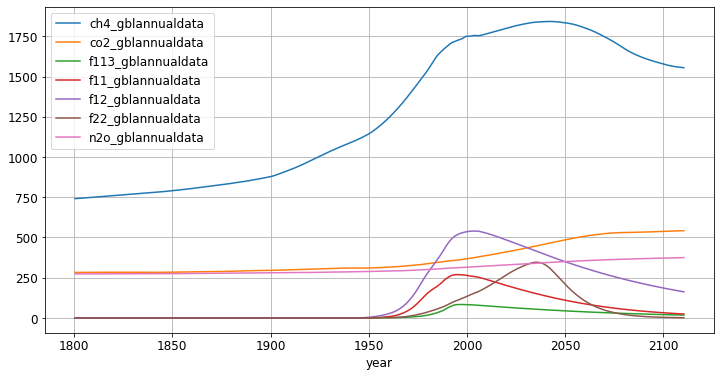

In [6]:
def read_gblannualdata(file_name):
    with open(file_name, "r") as data:
        next(data)
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return xr.DataArray(y, dims=("year"), coords={"year": x})


files = [
    "ch4_gblannualdata",
    "co2_gblannualdata",
    "f113_gblannualdata",
    "f11_gblannualdata",
    "f12_gblannualdata",
    "f22_gblannualdata",
    "n2o_gblannualdata",
]
for file in files:
    ds = read_gblannualdata(f"{INIT_dir}/{file}")
    ds.plot()
plt.grid()
_ = plt.legend(files)

Additional, `co2_obs.nc` to `co2_obs.padded.nc` are are provided to the bgc component of the model (see above). Their values are identical in the overlap period, but the future scenario appears to be different than that used for `co2_gblannualdata`:

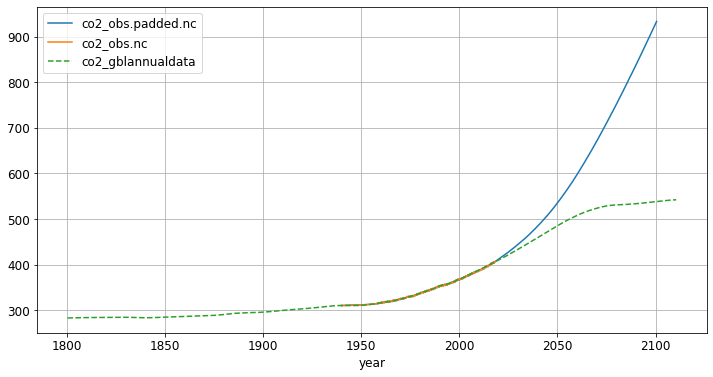

In [7]:
ds1 = xr.open_dataset(f"{INIT_dir}/co2_obs.nc", decode_times=False)
ds2 = xr.open_dataset(f"{INIT_dir}/co2_obs.padded.nc", decode_times=False)

ds1_gbl = ds1["co2"].mean(["grid_x_T", "grid_y_T"])
ds2_gbl = ds2["co2"].mean(["grid_x_T", "grid_y_T"])

plt.plot(ds2_gbl.time + 1700, ds2_gbl, label="co2_obs.padded.nc")
plt.plot(ds1_gbl.time + 1700, ds1_gbl, label="co2_obs.nc")
ds = read_gblannualdata(f"{INIT_dir}/co2_gblannualdata")
ds.plot(label="co2_gblannualdata", linestyle="--")

plt.grid()
_ = plt.legend()

Therefore

**We use time varying observed and projected radiative gas forcing out to 2110. However, it's not clear to me what scenario is used, or when the switch is made from observations to projections. The scenario used is different for `co2_gblannualdata` and `co2_obs.padded.nc`: it looks like `co2_gblannualdata` uses RCP4.5 and `co2_obs.padded.nc` uses RCP 8.5.**

### How are we inconsistent with CMIP6 DCPP?
The CMIP6 docs (https://doi.org/10.5194/gmd-9-1937-2016) request historical forcings are based as far as possible on observations and cover the period 1850–2014:

>The historical forcings are based as far as possible on observations and cover the period 1850–2014. These include:\
– emissions of short-lived species and long-lived greenhouse gases (GHGs),\
– GHG concentrations,\
– global gridded land-use forcing data sets,\
– solar forcing,
– stratospheric aerosol data set (volcanoes),\
– AMIP sea surface temperatures (SSTs) and sea ice concentrations (SICs),\
– for simulations with prescribed aerosols, a new approach to prescribe aerosols in terms of optical properties and fractional change in cloud droplet effective radius to provide a more consistent representation of aerosol forcing, and\
– for models without ozone chemistry, time-varying gridded ozone concentrations and nitrogen deposition.

Our,
 - **Aerosol climatology** data is just replicated from the 2000s onwards,
 - **Volcanic forcing** data is just replicated from 1999-12 onwards,
 - **Solar forcing** doesn't change
 
so these aren't consistent with CMIP6 specifications...

We appear to be using the CMIP6 **ozone forcing** data. But, I'm not sure we actually use it in a way consistent with the CMIP6 DCPP protocols (https://doi.org/10.5194/gmd-9-3751-2016) which states (Appendix A):

> The A1 hindcast experiment parallels the corresponding CMIP5 decadal prediction experiment in using the same specified forcing as is used for the CMIP6 historical climate simulations. This forcing is also used for the historical simulations of experiment A2. For forecasts which extend beyond the period for which historical forcing is specified, the “medium” SSP2-4.5 forcing of ScenarioMIP (O’Neill et al., 2016) is used.

and, from Table A1:

> Prescribed CMIP6 historical values of atmospheric composition and/or emissions (and other conditions including volcanic aerosols). Future forcing as the SSP2-4.5 scenario.

Does SSP2-4.5 provide ozone forcing? If so, our switch to 2014 forcing for forecasts initialised after 2004 goes against DCPP requests. If not, it's not clear to me what the DCPP expects one to do for future ozone.

It's not clear to me whether or not we are using observed **raditive gas forcing** from CMIP6, but my hunch is that the `*_gblannualdata` files transition from observations to scenarios in 2000.

### How are we inconsistent with CMIP5?
The CMIP5 docs (https://pcmdi.llnl.gov/mips/cmip5/docs/Taylor_CMIP5_design.pdf) request historical forcings are based as far as possible on observations and cover the period 1850–2005:
> - All forcings should be included as observed values for past dates, with prescribed concentrations of well-mixed GHGs. The details should be the same as used in the CMIP5 historical (20th century) runs (see Table 3), with the same flexibility on the treatment of ozone and aerosol and the same specified observational datasets. Note that with the exception of experiment 1.3, aerosols from observed volcanic eruptions should be included in all of the simulations.

where Table 3 gives:

> for CMIP5 historical (1850 - at least 2005), impose changing conditions (consistent with observations), which may include atmospheric composition (including CO2), due to both anthropogenic and volcanic influences; solar forcing; emissions or concentrations of short-lived species and natural and anthropogenic aerosols or their precursors; land use)

Also:

> - For future dates, the RCP4.5 scenario should be used if possible. Specification of reactive species and aerosols will follow those used in the long-term projection runs (see Table 4). With the exception of experiment 1.4, assume that there are no volcanic eruptions in the future (i.e., after year 2009).
> - Note the treatment of volcanic aerosol: observed values should be used for past dates, as per CMIP5, but values to be used after 2005 should be specified based on the assumption of no further volcanic eruptions. The model runs are thus configured to predict what will happen to climate, relative to the observed past, if no major eruptions take place, which is a possible outcome for a thirty year period.

But as above, our,
 - **Aerosol climatology** data is just replicated from the 2000s onwards,
 - **Volcanic forcing** data is just replicated from 1999-12 onwards,
 - **Solar forcing** doesn't change
 
so these aren't consistent with CMIP5 specifications either...

## 2. Change in CAFE60v1 bias correction scheme in 1992

The bias correction scheme used for CAFE60v1 (which provides the CAFE-f6 initial conditions) was changed at the beginning of 1992 (or thereabouts). From `O’Kane, T. J., Sandery, P. A., Kitsios, V., Sakov, P., Chamberlain, M. A., Collier, M. A., Fiedler, R., Moore, T. S., Chapman, C. C., Sloyan, B. M., & Matear, R. J. (2021). CAFE60v1: A 60-Year Large Ensemble Climate Reanalysis. Part I: System Design, Model Configuration, and Data Assimilation, Journal of Climate, 34(13), 5153-5169` (https://doi.org/10.1175/JCLI-D-20-0974.1):

"Prior to 1992, sea surface temperature (SST) is bias corrected using the method of Evensen (2003, section 4.2.2 therein) (see also O’Kane et al. 2019; Sandery et al. 2020). To estimate the SST bias field, an ensemble of bias fields is initialized to independently identically distributed random spatially uniform values and the observed SST is then assumed to be the sum of the model SST and unknown bias. This field is then updated similar to other model fields and the resulting ensemble of biases is evolved using a first-order autoregressive function [see paper for details]. Further, the SST bias influences subsurface temperature in the mixed layer, and therefore affects innovations from subsurface observations. Bias correction in this form can only detect and correct systematic errors in the initial conditions. Due to the relatively long assimilation window (calendar month), model SST bias was found to grow appreciably with lead time in particular regions and very specifically the South Pacific Ocean during the austral summer. Application of weak (90-day time scale) restoring to an SST climatology constructed from HadISST was applied to the forward model post 1992 to ameliorate the biases replacing the method of Evensen (2003)."

This change has a noticable and lasting impact on the CAFE-f6 forecasts, with forecasts initialised prior to 1992 demonstrating different behaviour than those initialised after 1992.

### Impact on CAFE60 initial conditions
Let's demonstrate the impact of the change in bias-correction scheme for a few monthly ocean variables, for example SST, which clearly shows the bias prior to 1992.

In [8]:
d60_ocean = xr.merge(
    [
        xr.open_zarr("../../data/raw/CAFE60v1/ocean_month.zarr.zip"),
        xr.open_dataset("../../data/raw/gridinfo/CAFE_ocean_grid.nc")[["area_t"]],
    ]
)

had = xr.open_zarr("../../data/raw/HadISST/ocean_month.zarr", use_cftime=True)
had = had.where(had > -1000)
had = xr.merge([had, utils.gridarea_cdo(had).rename("area")])

with Client() as client:
    sst_gbl = (
        d60_ocean["sst"]
        .mean("ensemble")
        .weighted(d60_ocean["area_t"])
        .mean(["xt_ocean", "yt_ocean"])
        .compute()
    )

    had_gbl = had["sst"].weighted(had["area"]).mean(["longitude", "latitude"]).compute()

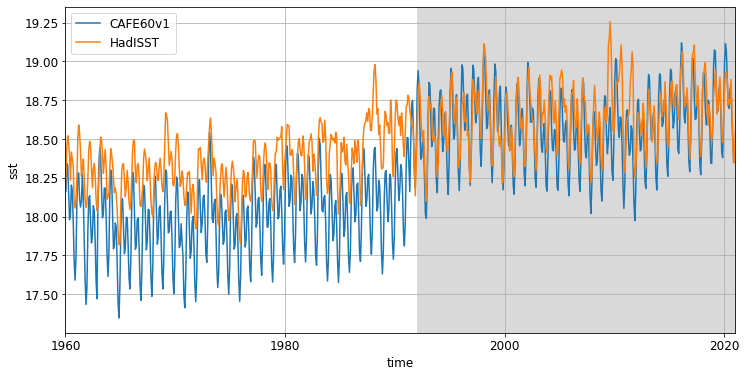

In [9]:
def shading(ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    trans = cftime.datetime(1992, 1, 1)
    end = cftime.datetime(2030, 1, 1)
    ax.fill_between(
        [trans, end], [ylim[1], ylim[1]], [ylim[0], ylim[0]], color=[0.85, 0.85, 0.85]
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


sst_gbl.plot(label="CAFE60v1")
had_gbl.plot(label="HadISST")
ax = plt.gca()
shading(ax)
ax.legend()
ax.grid()
_ = plt.xlim(cftime.datetime(1960, 1, 1), cftime.datetime(2021, 1, 1))

The change in bias correction scheme appears to induce a significant response in, for example, ocean temperature and salinity in the years following the change, particularly in the subsurface. Temperature increases and salinity decreases until the early 2000s, when increases in assimilated subsurface ocean observations presumably start to bring these variables back in line.

In [10]:
with Client() as client:
    ocean_gbl = (
        d60_ocean[["temp", "salt"]]
        .mean("ensemble")
        .chunk({"st_ocean": -1})
        .weighted(d60_ocean["area_t"])
        .mean(["xt_ocean", "yt_ocean"])
        .compute()
    )

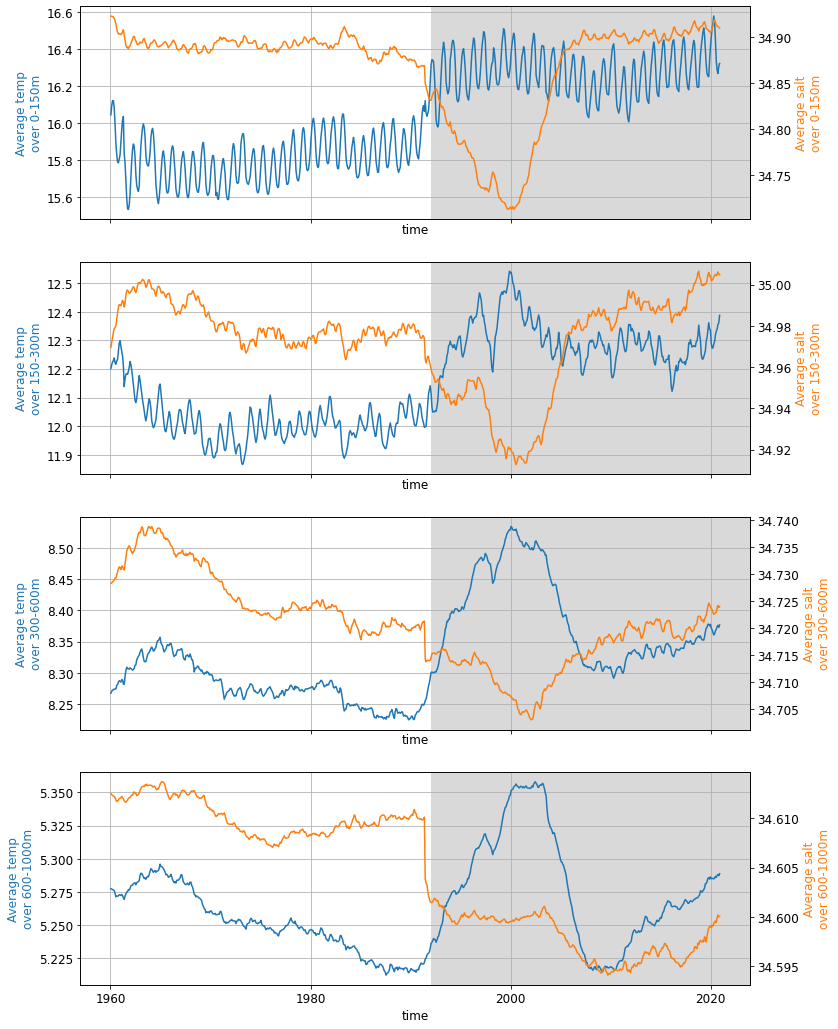

In [11]:
depth_ranges = [slice(0, 150), slice(150, 300), slice(300, 600), slice(600, 1000)]

fig, axs = plt.subplots(
    len(depth_ranges),
    1,
    figsize=(12, 18),
    sharex=True,
)

for i, r in enumerate(depth_ranges):
    axt = axs[i].twinx()
    d = ocean_gbl.sel(st_ocean=r).mean("st_ocean")
    d["temp"].plot(ax=axs[i], color="C0")
    d["salt"].plot(ax=axt, color="C1")
    shading(axs[i])
    axs[i].grid()
    axs[i].set_ylabel(f"Average temp\nover {r.start}-{r.stop}m", color="C0")
    axt.set_ylabel(f"Average salt\nover {r.start}-{r.stop}m", color="C1")

The step change observed in `salt` between 1991-05 and 1991-06 is the result of manually adding an offset (~1m) to the sea surface height after it was discovered that CAFE60v1 had been systematically losing water since it was started in 1960. This does not appear to be described in O’Kane et al. 2021 (see above for reference):

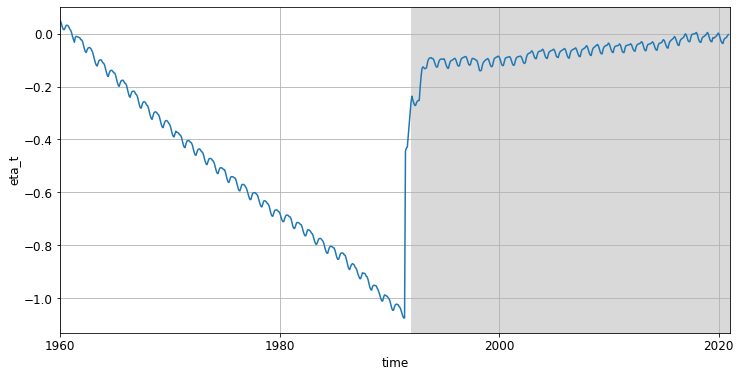

In [12]:
with Client() as client:
    ssh_gbl = (
        d60_ocean["eta_t"]
        .mean("ensemble")
        .weighted(d60_ocean["area_t"])
        .mean(["xt_ocean", "yt_ocean"])
        .compute()
    )

ssh_gbl.plot()
ax = plt.gca()
shading(ax)
ax.grid()
_ = plt.xlim(cftime.datetime(1960, 1, 1), cftime.datetime(2021, 1, 1))

The change due to the change in bias correction scheme is also very apparent in atmospheric variables, even though the bias-correction scheme is only applied to SST.

In [13]:
d60_atmos = xr.merge(
    [
        utils.truncate_latitudes(
            xr.open_zarr("../../data/raw/CAFE60v1/atmos_isobaric_month.zarr.zip")
        ),
        xr.open_dataset("../../data/raw/gridinfo/CAFE_atmos_grid.nc")[["area"]],
    ]
)

with Client() as client:
    atmos_gbl = (
        d60_atmos[["precip", "t_ref"]]
        .mean("ensemble")
        .chunk({"time": -1})
        .weighted(d60_atmos["area"])
        .mean(["lon", "lat"])
        .compute()
    )

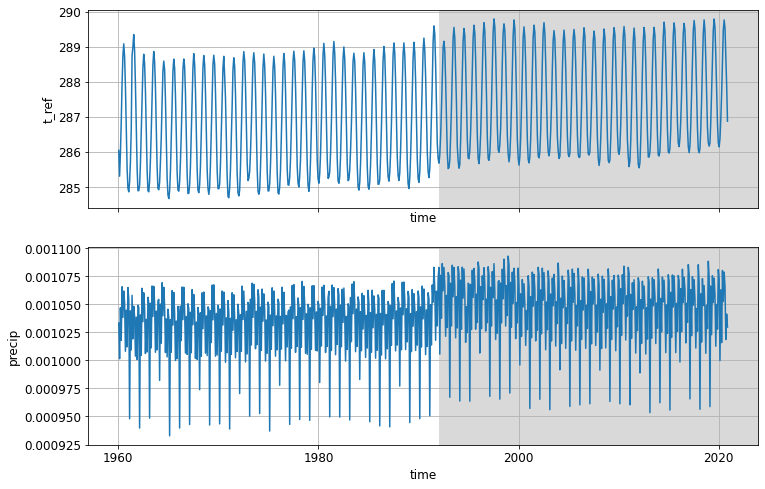

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

atmos_gbl["t_ref"].plot(ax=axs[0])
atmos_gbl["precip"].plot(ax=axs[1])
shading(axs[0])
shading(axs[1])
axs[0].grid()
axs[1].grid()

### Impact on CAFE-f6 forecasts
CAFE60v1 provides the initial conditions for the CAFE-f6 forecasts and so the change in bias correction scheme is also evident in the forecasts. The following shows annual-average November-initialised forecasts of various quanities. All show an apparent difference between forecasts initialised before and after 1992.

In [ ]:
identifiers = [
    "t_ref.annual.full", 
    "precip.annual.full", 
    "sst.annual.full", 
    "ohc300.annual.full"
]

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()

for i, v in enumerate(variables):
    ds = xr.open_zarr(f"../../data/processed/CAFEf6.{v}.zarr")
    da_gbl = ds.mean("member").weighted(ds["area"]).mean(["lon", "lat"])[v]
    da_gbl = da_gbl.assign_coords({"lead": ((da_gbl.lead - 11) / 12).astype(int)})
    da_gbl.rename(f"Global annual mean {da_gbl.name}").plot(ax=axs[i])

plt.subplots_adjust(wspace=0.2, hspace=0.1)

I've tried a few simple approaches to removing this discrepancy in postprocessing in the notebook on `Exploring CAFE-f6 bias correction`, but none were very successful.

## 3. Changes to MOM executable

After running the CAFE-f6 hindcasts/forecasts, it was discovered that a subset of the hindcasts were run using a version of the MOM executable that produced different behaviour than the other hindcasts/forecasts. The [forecast scripts](https://github.com/csiro-dcfp/cm-forecasts) used whatever MOM executable was available at run time in the directory `/home/548/pas548/src/mom_cafe` (see https://github.com/csiro-dcfp/cm-forecasts/blob/141ea91e095fb6f7285461bc4463ae31ca21801d/settings.sh#L105) and this executable was changed by user `pas548` (Paul Sandery) through time.

### Demonstration of unexpected bevaiour in a subset of the hindcasts

The plot below shows the global mean surface temperature averaged over lead years (where "Lead year 1" corresponds to the average over lead months 0-11, "Lead year 2" corresponds to the average over lead months 12-23 etc). The zig-zagging observed at later leads after 2005 comes about because the forecasts initialised in May (third panel) over this period trend towards a different free-running attractor than the other forecasts.

In [ ]:
data_dir = "../../data/raw/CAFEf6"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/atmos_isobaric_month.zarr.zip"))


def preprocess(ds):
    ds = utils.convert_time_to_lead(ds)
    ds = utils.truncate_latitudes(ds)
    ds = utils.coarsen_monthly_to_annual(ds, dim="lead")
    return ds


ds = xr.open_mfdataset(
    files,
    compat="override",
    preprocess=preprocess,
    engine="zarr",
    coords="minimal",
)["t_surf"]

ds_gbl = ds.mean("ensemble").weighted(ds["area"]).mean(["lat", "lon"]).compute()

In [ ]:
def plot_fig(ds, figsize):
    import matplotlib.pyplot as plt

    ylabel = f"Global {ds.name}"

    fig, (ax0, ax1, ax2) = plt.subplots(
        3,
        1,
        gridspec_kw={
            "height_ratios": [
                1,
                1,
                1,
            ]
        },
        figsize=figsize,
        sharex=True,
    )

    for lead in ds.lead.values:
        label = f"{int((lead+1)/12)}"
        ds.sel(lead=lead).plot.line(ax=ax0, x="init", label=label)

    ax0.legend(ncol=2, title="Lead year", loc="lower right", fontsize=10)

    ylim = ax0.get_ylim()
    ax0.set_title("")
    ax0.set_xlabel("")
    ax0.set_ylabel(ylabel)
    ax0.text(
        0.015,
        0.95,
        "All initialisation dates",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax0.transAxes,
    )
    ticks = xr.cftime_range("1980-01-01", "2022-01-01", freq="AS", calendar="julian")
    xlim = (ticks[0], ticks[-1])
    ax0.set_xticks(ticks.values, minor=True)
    ax0.grid(which="both")
    ax0.set_ylim(ylim)
    ax0.set_xlim(xlim)

    ds[1::2].plot.line(ax=ax1, x="init", add_legend=False)
    ax1.set_xlabel("")
    ax1.set_ylabel(ylabel)
    ax1.text(
        0.015,
        0.95,
        "November initialisations",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax1.transAxes,
    )
    ax1.set_xticks(ticks.values, minor=True)
    ax1.grid(which="both")
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)

    ds[::2].plot.line(ax=ax2, x="init", add_legend=False)
    ax2.set_xlabel("Initialisation date")
    ax2.set_ylabel(ylabel)
    ax2.text(
        0.015,
        0.95,
        "May initialisations",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax2.transAxes,
    )
    ax2.set_xticks(ticks.values, minor=True)
    ax2.grid(which="both")
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)

    return fig


fig = plot_fig(ds_gbl, (12, 12))

### Which forecast executables are different than the current one?

The script `../../data/testing/get_forecast_executables_from_tape.sh` retrieves all the CAFE-f6 MOM model executables from tape and stores them in `../../data/testing`.

Let's see which CAFE-f6 model executables are the same as a reference executable that was copied from `/home/548/pas548/src/mom_cafe` on 2022-01-25

In [ ]:
def mod_time(path):
    return time.strftime("%Y-%m-%d", time.localtime(os.path.getmtime(path)))


forecast_chronology = sorted(
    glob.glob(
        "../../data/testing/c5-d60-pX-f6-????????/c5-d60-pX-f6-????????-base/*/*/*/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-????????/MOM/fms_CM2M.x"
    )
)
forecast_chronology = {f: mod_time(f) for f in forecast_chronology}
forecast_chronology = dict(
    sorted(forecast_chronology.items(), key=lambda item: item[1])
)

reference_exectuable = "../../data/testing/reference_exectuable/fms_CM2M.x"

In [ ]:
def diff(a, b):
    p = subprocess.Popen(["diff", a, b], stdout=subprocess.PIPE)
    res, err = p.communicate()
    if not res:
        return True
    else:
        return False


for e, t in forecast_chronology.items():
    same = diff(e, reference_exectuable)
    if not same:
        print(
            f"{e.split('/')[4]} used a different exectable than the reference executable"
        )

So the majority of the model executables are different that the reference executable.

### When were changes made to the exectuable?

In [ ]:
for i in range(len(forecast_chronology) - 1):
    path_1 = list(forecast_chronology.keys())[i]
    path_2 = list(forecast_chronology.keys())[i + 1]
    date_1 = forecast_chronology[path_1]
    date_2 = forecast_chronology[path_2]
    same = diff(path_1, path_2)
    if not same:
        print(f"The executable was changed some time between {date_1} and {date_2}")

So a number of changes were made to the executable while the forecasts were being run.

### Which forecasts are reproducible with the reference executable? 

To answer this question conclusively, I ended up rerunning, using the reference exectuable, a single member of every forecast that used a different executable than reference executable. The complete set of rerun forecasts are archived on Gadi's tape system, see `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-????????-reproducibility_test`. The `ocean_scalar` model component for each rerun has been retained on spinning disk at `../../data/testing/c5-d60-pX-f6-????????-reproducibility_test`. The script `../../data/testing/get_reproducibility_data_from_tape.sh` retrieves all the `ocean_scalar` data for the rerun forecasts from tape and stores them in `../../data/testing`.

In [ ]:
def reproducible(forecast):
    orig_path = "../../data/raw/CAFEf6/"
    rerun_path = "../../data/testing/"

    rerun_forecast = f"{forecast}-reproducibility_test"
    if os.path.exists(f"{rerun_path}/{rerun_forecast}"):
        orig = xr.open_zarr(f"{orig_path}/{forecast}/ocean_scalar_month.zarr.zip")
        orig = orig["temp_total"].isel(ensemble=0).squeeze()

        rerun = xr.open_mfdataset(
            f"{rerun_path}/{rerun_forecast}/{rerun_forecast}-mem001/scratch/ux06/ds0092/CAFE/forecasts/f6/WIP/{rerun_forecast}/mem001/ocean_scalar_*.nc"
        )
        rerun = rerun["temp_total"].squeeze()

        return all(orig.values == rerun.values)
    else:
        return True


for e in forecast_chronology.keys():
    forecast = e.split("/")[4]
    repro = reproducible(forecast)
    if not repro:
        print(f"{forecast} is not reproducible with the reference executable")

### Putting this all together

In [ ]:
table = (
    "| Forecast name | Forecast run date | Same executable as reference? | Same executable as previous? | Reproducible? \n"
    "| -- | --- | :-: | :-: | :-: | \n"
)

for i in range(len(forecast_chronology)):
    if i == 0:
        path = list(forecast_chronology.keys())[i]
        date = forecast_chronology[path]
        same_as_prev = "-"
    else:
        path_prev = list(forecast_chronology.keys())[i - 1]
        path = list(forecast_chronology.keys())[i]
        date = forecast_chronology[path]
        same = diff(path, path_prev)
        if same:
            same_as_prev = "Y"
        else:
            same_as_prev = "**N**"

    forecast = path.split("/")[4]
    run_date = date

    same = diff(path, reference_exectuable)
    if same:
        same_as_ref = "Y"
    else:
        same_as_ref = "**N**"

    repro = reproducible(forecast)
    if repro:
        repro = "Y"
    else:
        repro = "**N**"

    table += (
        f"| {forecast} | {run_date} | {same_as_ref} | {same_as_prev} | {repro} | \n"
    )

| Forecast name | Forecast run date | Same executable as reference? | Same executable as previous? | Reproducible? 
| -- | --- | :-: | :-: | :-: | 
| c5-d60-pX-f6-20181101 | 2020-07-07 | **N** | - | Y | 
| c5-d60-pX-f6-20171101 | 2020-07-21 | **N** | Y | Y | 
| c5-d60-pX-f6-20161101 | 2020-07-29 | **N** | Y | Y | 
| c5-d60-pX-f6-20151101 | 2020-08-05 | **N** | Y | Y | 
| c5-d60-pX-f6-20141101 | 2020-08-10 | **N** | Y | Y | 
| c5-d60-pX-f6-20131101 | 2020-08-14 | **N** | Y | Y | 
| c5-d60-pX-f6-20111101 | 2020-08-18 | **N** | Y | Y | 
| c5-d60-pX-f6-20121101 | 2020-08-18 | **N** | Y | Y | 
| c5-d60-pX-f6-20101101 | 2020-08-24 | **N** | Y | Y | 
| c5-d60-pX-f6-20091101 | 2020-08-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20081101 | 2020-09-01 | **N** | Y | Y | 
| c5-d60-pX-f6-20071101 | 2020-09-10 | **N** | Y | Y | 
| c5-d60-pX-f6-20061101 | 2020-09-11 | **N** | Y | Y | 
| c5-d60-pX-f6-20051101 | 2020-09-25 | **N** | Y | Y | 
| c5-d60-pX-f6-20180501 | 2020-10-08 | **N** | **N** | Y | 
| c5-d60-pX-f6-20160501 | 2020-10-11 | **N** | **N** | **N** | 
| c5-d60-pX-f6-20170501 | 2020-10-11 | **N** | Y | **N** | 
| c5-d60-pX-f6-20130501 | 2020-10-14 | **N** | Y | **N** | 
| c5-d60-pX-f6-20140501 | 2020-10-14 | **N** | Y | **N** | 
| c5-d60-pX-f6-20150501 | 2020-10-14 | **N** | Y | **N** | 
| c5-d60-pX-f6-20120501 | 2020-10-23 | **N** | Y | **N** | 
| c5-d60-pX-f6-20110501 | 2020-10-24 | **N** | Y | **N** | 
| c5-d60-pX-f6-20100501 | 2020-10-28 | **N** | Y | **N** | 
| c5-d60-pX-f6-20090501 | 2020-10-29 | **N** | Y | **N** | 
| c5-d60-pX-f6-20080501 | 2020-10-30 | **N** | Y | **N** | 
| c5-d60-pX-f6-20070501 | 2020-11-01 | **N** | Y | **N** | 
| c5-d60-pX-f6-20060501 | 2020-11-02 | **N** | Y | **N** | 
| c5-d60-pX-f6-20050501 | 2020-11-12 | **N** | Y | **N** | 
| c5-d60-pX-f6-20190501 | 2020-11-16 | **N** | Y | **N** | 
| c5-d60-pX-f6-20200501 | 2020-11-17 | **N** | Y | **N** | 
| c5-d60-pX-f6-20201101 | 2020-12-27 | **N** | **N** | Y | 
| c5-d60-pX-f6-20021101 | 2021-02-09 | **N** | Y | Y | 
| c5-d60-pX-f6-20031101 | 2021-02-09 | **N** | Y | Y | 
| c5-d60-pX-f6-20041101 | 2021-02-09 | **N** | Y | Y | 
| c5-d60-pX-f6-20011101 | 2021-02-13 | **N** | Y | Y | 
| c5-d60-pX-f6-20001101 | 2021-02-17 | **N** | Y | Y | 
| c5-d60-pX-f6-19981101 | 2021-02-18 | **N** | Y | Y | 
| c5-d60-pX-f6-19991101 | 2021-02-18 | **N** | Y | Y | 
| c5-d60-pX-f6-19951101 | 2021-02-23 | **N** | Y | **N** | 
| c5-d60-pX-f6-19961101 | 2021-02-23 | **N** | Y | Y | 
| c5-d60-pX-f6-19971101 | 2021-02-23 | **N** | Y | Y | 
| c5-d60-pX-f6-19941101 | 2021-02-28 | **N** | Y | Y | 
| c5-d60-pX-f6-19921101 | 2021-03-22 | **N** | Y | Y | 
| c5-d60-pX-f6-19931101 | 2021-03-22 | **N** | Y | Y | 
| c5-d60-pX-f6-19911101 | 2021-03-24 | **N** | Y | Y | 
| c5-d60-pX-f6-19901101 | 2021-03-25 | **N** | Y | Y | 
| c5-d60-pX-f6-19891101 | 2021-03-28 | **N** | Y | Y | 
| c5-d60-pX-f6-19861101 | 2021-04-01 | **N** | Y | Y | 
| c5-d60-pX-f6-19871101 | 2021-04-01 | **N** | Y | Y | 
| c5-d60-pX-f6-19881101 | 2021-04-01 | **N** | Y | Y | 
| c5-d60-pX-f6-19841101 | 2021-04-13 | **N** | Y | Y | 
| c5-d60-pX-f6-19851101 | 2021-04-13 | **N** | Y | Y | 
| c5-d60-pX-f6-19811101 | 2021-04-21 | **N** | Y | Y | 
| c5-d60-pX-f6-19821101 | 2021-04-21 | **N** | Y | Y | 
| c5-d60-pX-f6-19831101 | 2021-04-21 | **N** | Y | Y | 
| c5-d60-pX-f6-20020501 | 2021-04-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20030501 | 2021-04-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20040501 | 2021-04-26 | **N** | Y | Y | 
| c5-d60-pX-f6-20000501 | 2021-05-02 | **N** | Y | Y | 
| c5-d60-pX-f6-20010501 | 2021-05-02 | **N** | Y | Y | 
| c5-d60-pX-f6-19970501 | 2021-05-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19980501 | 2021-05-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19990501 | 2021-05-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19950501 | 2021-05-15 | **N** | **N** | Y | 
| c5-d60-pX-f6-19960501 | 2021-05-15 | **N** | Y | Y | 
| c5-d60-pX-f6-19940501 | 2021-05-16 | **N** | Y | Y | 
| c5-d60-pX-f6-19920501 | 2021-06-02 | **N** | Y | Y | 
| c5-d60-pX-f6-19930501 | 2021-06-02 | **N** | Y | Y | 
| c5-d60-pX-f6-19900501 | 2021-06-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19910501 | 2021-06-07 | **N** | Y | Y | 
| c5-d60-pX-f6-19870501 | 2021-06-21 | Y | **N** | Y | 
| c5-d60-pX-f6-19880501 | 2021-06-21 | Y | Y | Y | 
| c5-d60-pX-f6-19890501 | 2021-06-21 | Y | Y | Y | 
| c5-d60-pX-f6-19860501 | 2021-06-28 | Y | Y | Y | 
| c5-d60-pX-f6-19850501 | 2021-07-18 | Y | Y | Y | 
| c5-d60-pX-f6-19840501 | 2021-08-03 | Y | Y | Y | 
| c5-d60-pX-f6-19830501 | 2021-08-12 | Y | Y | Y | 
| c5-d60-pX-f6-19820501 | 2021-09-17 | Y | Y | Y | 
| c5-d60-pX-f6-19810501 | 2021-11-10 | Y | Y | Y | 
| c5-d60-pX-f6-20191101 | 2022-01-28 | Y | Y | Y | 

All May forecasts from 2005-05-01 to 2020-05-01, excluding 2018-05-01, are not reproducible. I spent some time with Paul Sandery (who changed the executable) trying to establish what exactly was different about the executable for these forecasts. Unfortunately, Paul did not `git commit` the changes he was making to the repo containing the executable (https://bitbucket.csiro.au/projects/DF/repos/mom_cafe/browse; Internal CSIRO only) so there is no record fo what changed.

Paul thought that the main changes he made to the MOM source code around the problem period were in `ice_dyn.F90`. In particular, Paul flagged line 250 of `ice_dyn.F90` as one he had changed.

In the reference executable (), line 250 reads:
``` fortran
if( (wett(i,j)>0.5) .and.(ci(i,j)*(DI*hi(i,j)+DS*hs(i,j))>MIV_MIN) .and. (edt(i,j)>0) ) then
```

Paul provided two new executables, compiled with

**a)**
``` fortran
if( (wett(i,j)>0.5) .and.(ci(i,j)*(DI*hi(i,j)+DS*hs(i,j))>MIV_MIN) ) then
```

**b)**
``` fortran
if( (wett(i,j)>0.5) .and.(ci(i,j)*(DI*hi(i,j)+DS*hs(i,j))>MIV_MIN) .and. (edt(i,j)>0) .and. (strn11(i,j)>0) .and. (strn22(i,j)>0) ) then
```

The former (**a**) is what is in the original [MOM5 repo](https://github.com/mom-ocean/MOM5/blob/9b8ec93983a54e4b8d9d148eb6863b8ac94fbce3/src/ice_sis/ice_dyn.F90#L249). The latter (**b**) is a change that Paul thinks he may have made at some point.

I ran test runs with each of these new executables to see if either reproduces the behaviour of the problem May forecasts. Change **a** produced results identical to those produced by the reference executable. Change **b** produced results that are different than both those produced by the reference executable and those produced by the executable used for the problem May forecasts.

These runs are archived on Gadi tape storage:
- Rerun of 2006-05-01 using reference executable: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-rerun`
- Rerun of 2006-05-01 using executable compiled with **a**: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-ORIG_ice_dyn.F90`
- Rerun of 2006-05-01 using executable compiled with **b**: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-TRANSIENT_ice_dyn.F90`
- Rerun of 2006-05-01 using executable from 2020-11-02: `mdss -P xv83 dmls -l f6/c5-d60-pX-f6-20060501-rerun-oldexec`

**Until we can work out exactly what was changed to produce the problem May forecasts, the approach in this project is to use only the November-initialised forecasts.**

### Why is c5-d60-pX-f6-19951101 not reproducible?
c5-d60-pX-f6-19951101 is not reproducible, but this forecast was not run during the period when the model executable was inconsistent. Let's take a look at what's different between the original run and the reproducibility run.

In [ ]:
orig = (
    xr.open_zarr(
        "../../data/raw/CAFEf6/c5-d60-pX-f6-19951101/ocean_scalar_month.zarr.zip"
    )["temp_total"]
    .isel(ensemble=0)
    .squeeze()
)

rerun = xr.open_mfdataset(
    "../../data/testing/c5-d60-pX-f6-19951101-reproducibility_test/c5-d60-pX-f6-19951101-reproducibility_test-mem001/scratch/ux06/ds0092/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-19951101-reproducibility_test/mem001/ocean_scalar_*.nc"
)["temp_total"].squeeze()

difference = orig - rerun

In [ ]:
fig, (ax0, ax1) = plt.subplots(
    2,
    1,
    sharex=True,
)

orig.plot(ax=ax0, label="Original run")
rerun.plot(ax=ax0, label="Reproducibility run")
ax0.legend()
ax0.set_xlabel("")
ax0.set_title("")

difference.plot(ax=ax1, label="Difference")
ax1.set_ylabel("Difference")
_ = ax1.set_title("")

These start to deviate in the 71st month of the forecast. But both forecasts were run as single cycle, so I don't really understand how this could happen. Is it possible that something external changed (e.g. the forcing files or Gadi itself)? This doesn't seem that plausible to me...

## 4. Changes to model timesteps

It is not uncommon for the CAFE model to become unstable during a run. For most of the CAFE-f6 forecasts, the standard approach for resolving this issue was to restart the forecast with reduced model timesteps. There are three timesteps used by CAFE:

```
dt_atmos   <- the atmospheric component time step [s]
dt_ocean   <- the ocean component time step [s]
dt_cpld    <- the coupling time step [s]
```

Most CAFE-f6 runs use the default values of `dt_atmos = 1800, dt_ocean = 1800, dt_cpld = 1800` (see https://github.com/csiro-dcfp/cm-forecasts/blob/ccf838e5d1ac7f71c63cda6a43e5eee5280fff4c/settings.sh#L116). However, some runs that fell over were rerun with `dt_atmos = 1200, dt_ocean = 1200, dt_cpld = 1200` or even `dt_atmos = 900, dt_ocean = 900, dt_cpld = 900` if that was also unsuccessful.

It was subsequently discovered that adjusting `dt_atmos` can substantially effect the free-running attractor of the model, see https://github.com/dougiesquire/cm-historical/blob/0d7c4601592b5b337d77f3c04228f1a0f67d76c2/notebooks/hist_mem001.ipynb. This is very evident in the forecast members that were run with a reduced atmospheric time step:

In [ ]:
data_dir = "../../data/raw/CAFEf6/c5-d60-pX-f6-20201101/"
file = f"{data_dir}//atmos_isobaric_month.zarr.zip"

ds = xr.open_zarr(
    f"{data_dir}/atmos_isobaric_month.zarr.zip",
)["t_surf"]

ds_gbl = ds.weighted(ds["area"]).mean(["lat", "lon"]).compute()

In [ ]:
reduced_dt_ensembles = [27, 37, 51, 76]
ds_reduced_dt = ds_gbl.sel(ensemble=reduced_dt_ensembles)
ds_default_dt = ds_gbl.sel(
    ensemble=list(set(ds_gbl.ensemble.values) - set(reduced_dt_ensembles))
)

p0 = ds_default_dt.plot.line(x="time", add_legend=False, color="C0")
p1 = ds_reduced_dt.plot.line(x="time", add_legend=False, color="C1")
plt.ylabel(f"Global {ds_default_dt.name}")
plt.grid()
plt.title(f"Forecast initialised {data_dir.split('/')[-2][-8:]}")
_ = plt.legend([p0[0], p1[0]], ["all dt = 1800", "all dt = 1200"])

I've generated a mask for the forecasts that were run at a reduced timestep so that these forecasts can be readily removed from analysis. 

In [ ]:
dt_mask = xr.open_dataset("../../data/raw/CAFEf6/CAFE-f6_dt_atmos.nc")["dt_atmos"]
dt_mask.plot()

reduced_dt = xr.where(dt_mask < 1800, 1, 0)
print(
    (
        f"The total number of forecasts run with reduce dt_atmos is {reduced_dt.sum().values},"
        f" which is {100 * reduced_dt.mean().values}% of the CAFE-f6 dataset"
    )
)

Note that moving forward, I've found that users can change `dt_ocean` without (obviously) effecting the free-running attractor of CAFE (see https://github.com/dougiesquire/cm-historical/blob/0d7c4601592b5b337d77f3c04228f1a0f67d76c2/notebooks/hist_mem001.ipynb). All forecasts run since that became unstable were rerun with `dt_atmos = 1800, dt_ocean = 900, dt_cpld = 1800`.